This homework is based off a notebook. 
1. You will alter this as need for your results / questions. 
2. When you've successfully run them on a colab, download as an .ipynb and submit on the LMS.

Make certain you are on a GPU Runtime first, by going to Runtime and selecting "Change Runtime Type", and then choosing Hardware Accelerator as GPU.

In this homework, you will build an emotion classifier based on a Huggingface emotions dataset.

You will need to install 🤗 Transformers, numpy and 🤗 Datasets. Run the following three cells.

In [ ]:
pip install datasets==1.3.0

     |████████████████████████████████| 184kB 17.3MB/s 
     |████████████████████████████████| 112kB 37.8MB/s 
     |████████████████████████████████| 245kB 47.8MB/s 


In [ ]:
pip install transformers==4.3.2

     |████████████████████████████████| 1.8MB 17.1MB/s 
     |████████████████████████████████| 3.2MB 52.1MB/s 
     |████████████████████████████████| 890kB 48.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9ef57a460aa00aa0614c7764c264a5694a757fac219f79892deaa68762fb9324
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
pip install numpy==1.20.1

     |████████████████████████████████| 15.3MB 216kB/s 
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll have numpy 1.20.1 which is incompatible.
ERROR: jaxlib 0.1.60+cuda101 has requirement numpy<1.20,>=1.12, but you'll have numpy 1.20.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5


In [ ]:
from datasets import load_dataset
emotions_dataset = load_dataset('go_emotions', 'simplified')

Dataset go_emotions downloaded and prepared to /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e. Subsequent calls will reuse this data.


To get a sense of what the data looks like, the following function will show some examples picked randomly in the dataset.

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
# For simplicity, train model with single label for item.
restricted_dataset = emotions_dataset.filter(lambda x: len(x["labels"]) == 1 and 27 not in x['labels'])
print(len(restricted_dataset['train']))
show_random_elements(restricted_dataset['train'])


23485


,id,labels,text
0,eel0stp,[7],"How is that relevant? The rules are simple, do not attack character."
1,eezockc,[4],My bf just got this too. He's obsessed
2,ed8688n,[15],"Thanks, came here for this"
3,eetdm2z,[20],De un tronco a otro. I hope they wake up!
4,edl4p8u,[18],Just remember I love you
5,ef53gyx,[22],Oh ok. I was looking at the wrong subs then. Good to know.
6,eegzb3v,[2],I'm not surprised to read this within the sub it's in. Bunch of knuckle dragging storm troopers WOULD be angry to see people liberate themselves. XD
7,edfongj,[2],TRENDY PEOPLE DANCING WITH PRODUCTS
8,efakiz0,[20],I hope that stays on all their programs from now on. Would really add a new element to Corrie.
9,ed1m83t,[15],Your inability to formulate an argument is what's most humorous. Oh great philosophers of free speech... Thanks for the laugh. Happy New Year!



The emotions are provided as numeric labels. These are the actual orderings, beginning at 0 for admiration:

In [ ]:
labels = ["Negative", "Positive", "Negative", "Negative", "Negative", "Negative", 
          "Positive", "Positive", "Positive", "Negative", "Negative",
          "Negative", "Negative", "Positive", "Negative", "Positive", "Negative",
          "Positive", "Positive", "Positive", "Positive", "Negative", "Positive",
          "Positve", "Negative", "Negative", "Positive", "neutral"]
index_to_labels = {index: label for index, label in enumerate(labels)}
  

## Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a 🤗 Transformers `Tokenizer` which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the `AutoTokenizer.from_pretrained` method, which will ensure:

- we get a tokenizer that corresponds to the model architecture we want to use,
- we download the vocabulary used when pretraining this specific checkpoint.

That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

In [ ]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer

model_name = 'distilbert-base-uncased'
config = AutoConfig.from_pretrained(model_name, num_labels=27)
model = AutoModelForSequenceClassification.from_config(config=config)
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

We pass along `use_fast=True` to the call above to use one of the fast tokenizers (backed by Rust) from the 🤗 Tokenizers library. Those fast tokenizers are available for almost all models, but if you got an error with the previous call, remove that argument.

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples['text'], truncation=True)

def convert_labels_to_int(example):
    example['labels'] = example['labels'][0]
    return example

encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.map(convert_labels_to_int)

## Fine-tuning the model

Here we set the evaluation to be done at the end of each epoch, tweak the learning rate, use the `batch_size` defined at the top of the notebook and customize the number of epochs for training, as well as the weight decay. Since the best model might not be the one at the end of training, we ask the `Trainer` to load the best model it saved (according to `metric_name`) at the end of training.

In [ ]:
metric = datasets.load_metric('accuracy')
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

## Single Function for processing different model

In [ ]:
import numpy as np
from transformers import Trainer, TrainingArguments
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer


def build_and_evaluate_model(learning_rate, train_batch, eval_batch, epochs, weight, model_name): 

  model_name = model_name
  config = AutoConfig.from_pretrained(model_name, num_labels=27)
  model = AutoModelForSequenceClassification.from_config(config=config)
  tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
  
  encoded_dataset = restricted_dataset.map(preprocess_function, batched=True)
  encoded_dataset = encoded_dataset.map(convert_labels_to_int)

  metric_name = "accuracy"


  args = TrainingArguments(
      "test-emotions",
      evaluation_strategy = "epoch",
      learning_rate=learning_rate,
      per_device_train_batch_size=train_batch,
      per_device_eval_batch_size=eval_batch,
      num_train_epochs=epochs,
      weight_decay=weight,
      load_best_model_at_end=True,
      metric_for_best_model=metric_name,
  )

  validation_key = "validation"
  trainer = Trainer(
      model,
      args,
      train_dataset=encoded_dataset["train"],
      eval_dataset=encoded_dataset["validation"],
      tokenizer=tokenizer,
      compute_metrics=compute_metrics
  )

  print("Model is training ........")
  trainer.train()
  trainer.evaluate

## DistillBert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 4, 0.01, 'distilbert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-7baf20fc27e04c29.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-c06c4295e2555955.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-e3ee3d883725689b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-48a2965898e8d5c1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-6059ff6e2539cf27.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.588100,1.854359,0.500677,6.922300,427.027000
2,1.936600,1.669261,0.537212,6.926900,426.745000
3,1.532300,1.566117,0.569350,6.935700,426.204000
4,1.447200,1.548396,0.566306,6.969100,424.158000


In [ ]:
build_and_evaluate_model(3e-3, 64, 64, 3, 0.001, 'distilbert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-7baf20fc27e04c29.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-c06c4295e2555955.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-e3ee3d883725689b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-48a2965898e8d5c1.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-6059ff6e2539cf27.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,3.004126,0.110284,6.774000,436.374000
2,3.045000,3.004128,0.110284,6.766900,436.831000
3,3.027200,3.001214,0.110284,6.763600,437.045000


## Bert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 3, 0.01, 'bert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-5b7b8ab772073245.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-547b10fecd7ffa8b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-2721a73555ceb4d5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-60966b980c4e6b78.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-9f77c349884851a4.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.614400,1.890321,0.489175,6.352900,465.297000
2,1.983200,1.749358,0.521651,6.356600,465.029000
3,1.611000,1.643442,0.551083,6.378500,463.432000


In [ ]:
build_and_evaluate_model(3e-3, 64, 64, 2, 0.001, 'bert-base-uncased')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-5b7b8ab772073245.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-547b10fecd7ffa8b.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-2721a73555ceb4d5.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-60966b980c4e6b78.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-9f77c349884851a4.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,No log,3.137151,0.087280,6.004100,492.328000
2,3.234600,3.010047,0.110284,6.022400,490.831000


## Albert Model

In [ ]:
build_and_evaluate_model(2e-5, 32, 32, 2, 0.01, 'albert-base-v2')


Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.690400,2.169227,0.408660,7.212000,409.874000
2,2.195000,2.000359,0.455345,7.200000,410.556000


In [ ]:
build_and_evaluate_model(2e-3, 32, 32, 2, 0.02, 'albert-base-v2')

Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-99e2e3051dd8613c.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-4786ddc014d62ee3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-1e69ae1ddd7d7836.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-483f40e8a1b92bad.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/go_emotions/simplified/0.0.0/ef1c18ea192c771555f1e0d638889dd5f1896255782c57c6a0b934d5f94f779e/cache-a2c3dff41d711486.arrow
Loading cached processed dataset at

Model is training ........


Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,3.294500,3.196371,0.070365,6.863500,430.687000
2,3.156500,3.006661,0.110284,6.852400,431.384000


Then we just need to pass all of this along with our datasets to the `Trainer`:

We can now finetune our model by just calling the `train` method:

In [ ]:
prepared_input = tokenizer.prepare_seq2seq_batch(["I am very sad"], return_tensors='pt')
model = model.to('cpu')
model.eval()
model_output = model(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
index_to_labels[prediction]

'Negative'


# Automatic Hyperaparameter Tunning

In [ ]:
pip install optuna

     |████████████████████████████████| 296kB 17.5MB/s 
     |████████████████████████████████| 81kB 12.6MB/s 
     |████████████████████████████████| 163kB 54.7MB/s 
     |████████████████████████████████| 112kB 53.5MB/s 
     |████████████████████████████████| 143kB 56.9MB/s 
     |████████████████████████████████| 51kB 8.6MB/s 
     |████████████████████████████████| 81kB 12.8MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-cp37-none-any.whl size=11107 sha256=46f520d7ee6c470095bd613654a530f637e22296fa6265476506f00112bb92a5
  Stored in directory: /root/.cache/pip/wheels/25/af/b8/3407109267803f4015e1ee2ff23be0c8c19ce4008665931ee1
Successfully built pyperclip


In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=27)

In [ ]:
from transformers import Trainer, TrainingArguments
metric_name = "accuracy"

args = TrainingArguments(
    "test-emotions",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
)

In [ ]:
validation_key = "validation"
trainer = Trainer(
    model_init=model_init,
    args=args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

In [ ]:
train_dataset = encoded_dataset["train"].shard(index=1, num_shards=2) 

In [ ]:
import numpy as np
best_run = trainer.hyperparameter_search(n_trials=2, direction="maximize")

[I 2021-03-08 09:20:46,455] A new study created in memory with name: no-name-0a462fe5-19e5-43d1-8503-ac899454265f
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpo

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.703500,2.494405,0.353518,3.233500,914.189000
2,2.247200,2.096796,0.470230,3.222900,917.174000
3,2.038700,1.933804,0.502368,3.242700,911.598000
4,1.954300,1.887527,0.514547,3.224700,916.682000


Epoch,Training Loss,Validation Loss


[I 2021-03-08 09:31:24,831] Trial 0 finished with value: 920.4212466847091 and parameters: {'learning_rate': 1.2182420368964714e-06, 'num_train_epochs': 4, 'seed': 40, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 920.4212466847091.
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,1.454000,1.359796,0.628214,3.229500,915.314000


[I 2021-03-08 09:34:07,676] Trial 1 finished with value: 919.1717138024356 and parameters: {'learning_rate': 1.5345154848313283e-05, 'num_train_epochs': 1, 'seed': 22, 'per_device_train_batch_size': 8}. Best is trial 0 with value: 920.4212466847091.


In [ ]:
best_run

BestRun(run_id='0', objective=920.4212466847091, hyperparameters={'learning_rate': 1.2182420368964714e-06, 'num_train_epochs': 4, 'seed': 40, 'per_device_train_batch_size': 8})

In [ ]:
 import dill
 import pickle
 with open("modelQ3.dill", "wb") as f:
        dill.dump(model, f, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
if __name__ == "__main__":
    # Load the model
    with open("/content/modelQ3.dill", "rb") as f:
        model = dill.load(f)

In [ ]:
prepared_input = tokenizer.prepare_seq2seq_batch(["I am very happy"], return_tensors='pt')
model = model.to('cpu')
model.eval()
model_output = model(**prepared_input)
prediction = np.argmax(model_output.logits[0].detach().numpy())
index_to_labels[prediction]

'Positive'

In [ ]:
import numpy as np

mytrainer = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Runtime,Samples Per Second
1,2.663100,2.026286,0.437077,6.552700,451.108000
2,2.093700,1.783051,0.518268,6.568300,450.038000


In [ ]:

evalValue = trainer.evaluate()


In [ ]:
for key, value in evalValue.items():
	    print("{}: {}".format(key, value))

eval_loss: 1.783050775527954
eval_accuracy: 0.5182679296346414
eval_runtime: 6.3931
eval_samples_per_second: 462.372
epoch: 2.0


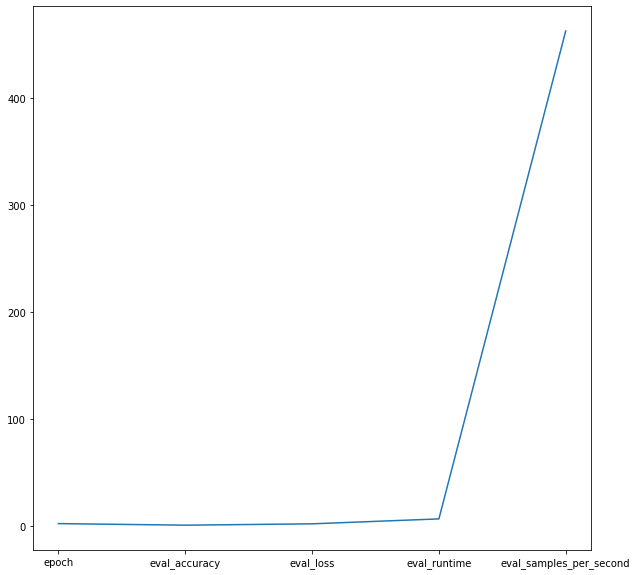

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(*zip(*sorted(evalValue.items())))
plt.show()

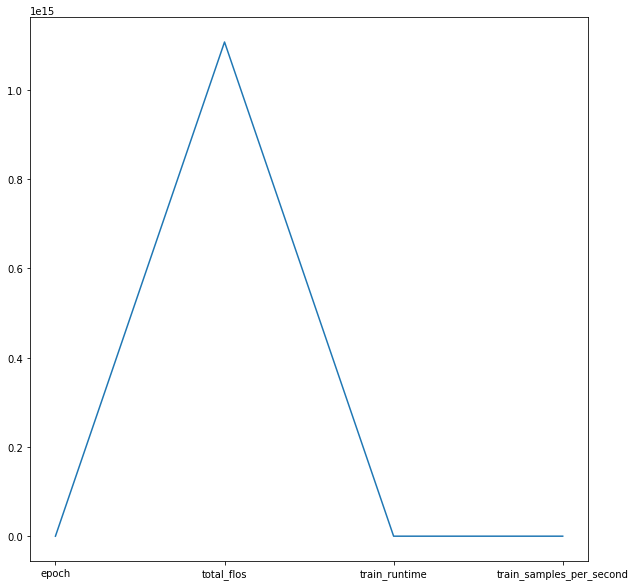

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(*zip(*sorted(mytrainer.metrics.items())))
plt.show()

# Your work

Qs 1. Can you report how accuracy changes with varying the hypyerparameters defined above? How does accuracy change with increasing number of epochs? Learning rate? Mention your final choice of parameters and graph how they impact accuracy. 

Qs 2. Try any 2 other models for sequence classification supported by Huggingface and repeat Qs 1 for these. You can find a full list of these [here](https://huggingface.co/transformers/model_doc/auto.html#automodelforsequenceclassification). (For those of you working with text for your project, you may also find several other useful models for Seq2Seq modeling, question answering, etc.)

Qs 3. Wrangle / change the data so that you can instead build a "positive" emotion vs "negative" emotions classifier, by combining labels. For any emotions that you feel are too neutral, you may drop them from evaluation. Can you now report the accuracy of a classifer on this data? You may use one of the model architectures from (1) or (2)

Qs 4. Export models from qs 1 and 3, and build a FastAPI around it, as discussed in class, which returns the most likely emotion found. (You may need to look up Huggingface documentation on how to save and load models). In particular, you should support two API endpoints - "detect_emotion_binary" and "detect_emotion_full" which supports each model.

Qs 5. Finally, can you dockerize this? You do NOT need to deploy this to the cloud.

Submission instructions: Zip your compiled .ipynb notebook, your fast_api code and your dockerfile, and submit to LMS as one file. You should confirm that your .ipynb can be imported to colab and run in sequence. All your results for Qs 1-3 should be reported in the notebook itself.

## Question No 1-2:  Answer


For all three models, I have found hyperparameters impact on accuracy was mostly same.

**No of Epochs**

 Accuracy can vary by changing hyperparameters. As I have used 4 epochs, so in my case increasing the number of epochs can increase the accuracy. Increasing also lead the model towards overfitting.

**Learning Rate**

By decreasing the learning rate the model will take long to train the model and by increasing it may exceed the optimal. Here as by increasing the learning rate which was 2e-5 to 3e-3 has also decreased the accuracy.

**Batch Size**

If you increase the batch size it may provide poor generalization. Here increasing batch size has decreased the accuracy.

**Decay Weight**
Increasing the decay weight also decreases the accuracy here. 

**Best Parameter: manually**
Here I have found the best values for tunnin hyperparameter are

epoch = 5

Lr = 2e-5

batch_size = 32

decay weight = 0.01

however these are not best as we have limited disk n memory here so we can apply automatic tunning by optuna or ray.

**Automatic Tunning Resutls**
which are mostly same as manual

Epoch = 5

batch_size = 32

lr = 2-e6

